In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/plotting_codes", "")
    meta_dir = base_dir + "/9_Figures/9_Meta"

In [3]:
###----- Genes information -- var
var_file = base_dir + '/0_Acute-Chronic/1_Scanpy/0_Scanpy_out_resampled/0_Acute-Chronic_paga/var.csv'
var_df = pd.read_csv(var_file, index_col=0)
highly_variable_genes = var_df[var_df['highly_variable'] == True].index.tolist()
highly_variable_highly_expressed_genes = var_df[var_df['means'] > 0.01].index.tolist()
highly_variable_highly_expressed_genes = [x for x in highly_variable_highly_expressed_genes if "mt-" not in x]

###----- IL2ra stat5 promoted genes
il2_stat5_promoted_file = base_dir + '/9_Figures/9_Meta/Il2-stat5_direct_promoted.csv'
il2_stat5_promoted_genes = pd.read_csv(il2_stat5_promoted_file)['gene_name'].tolist()

il2_stat5_repressed_file = base_dir + '/9_Figures/9_Meta/Il2-stat5_direct_repressed.csv'
il2_stat5_repressed_genes = pd.read_csv(il2_stat5_repressed_file)['gene_name'].tolist()

In [4]:
###----- Arm v.s. Cl13 log2fc compiling
avc_dir = base_dir + '/0_Acute-Chronic/1_Scanpy/0_Scanpy_out_resampled/2_DE/perCluster_Arm_vs_Cl13'
avc_sample = avc_dir + '/P2/A/A_vs_C_differential.csv'
i = 2
i_avc_file = avc_dir + '/P%s/A/A_vs_C_differential.csv'%i
avc_df = pd.read_csv(i_avc_file, index_col=0)[[]]

for i in range(2, 8):
    i_avc_file = avc_dir + '/P%s/A/A_vs_C_differential.csv'%i
    i_avc_df = pd.read_csv(i_avc_file, index_col=0)
    # For padj >= 0.1, ignore log2fc
    i_avc_df_sig = [True if i_avc_df['t-test_overestim_var_padj'][x] < 0.1 else False 
                    for x in range(0, len(i_avc_df))]
    i_avc_df['log2fc'] = [ i_avc_df['t-test_logfc'].tolist()[x] if i_avc_df_sig[x] == True 
                          else 0 for x in range(0, len(i_avc_df)) ]
    # If one of the conditions has < 0.01 expr value, ignore log2fc
    i_avc_min_expr = i_avc_df[i_avc_df.columns.tolist()[:2]].min(axis=1)
    min_cutoff = i_avc_min_expr > 0.01
    i_avc_df['log2fc'] = [ i_avc_df['t-test_logfc'].tolist()[x] if min_cutoff[x] == True 
                          else 0 for x in range(0, len(i_avc_df)) ]
    # Compile
    i_avc_df = i_avc_df[['log2fc']]
    i_avc_df.columns = ["P%s"%i]
    avc_df = avc_df.join(i_avc_df)

# Select genes that are highly variabel and higly expressed
avc_hv_df = avc_df.loc[highly_variable_highly_expressed_genes]
# Select genes that are at least abs(log2fc) > 0.25
max_list = avc_hv_df.max(axis=1)
min_list = avc_hv_df.min(axis=1)
use_bool = [True if max_list[i] > 0.2 or min_list[i] < -0.2 else False for i in range(0, len(max_list))]
avc_hv_df_slt = avc_hv_df[ use_bool ]
# Sqrt of log2fc
avc_hv_df_slt_sqrt = avc_hv_df_slt.copy()
for i in avc_hv_df_slt.columns:
    avc_hv_df_slt_sqrt[i] = abs(avc_hv_df_slt[i]) / avc_hv_df_slt[i] * np.sqrt(abs(avc_hv_df_slt[i]))
# Fill in 0 for NA   
avc_hv_df_slt_sqrt = avc_hv_df_slt_sqrt.fillna(0)

/home/pipkin/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


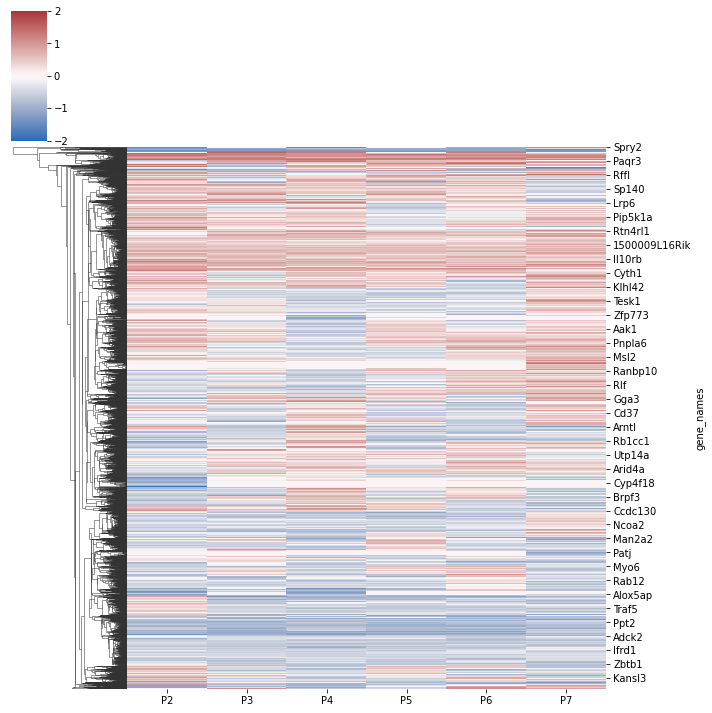

In [5]:
sns.clustermap(avc_hv_df_slt_sqrt, cmap="vlag", vmin=-2, vmax=2,
               col_cluster=False, method='centroid')

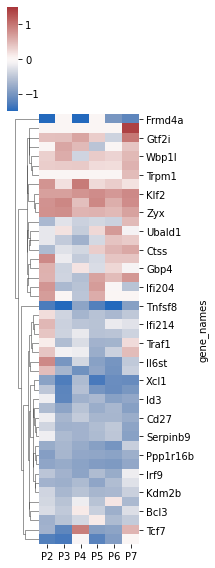

In [6]:
###----- Il2 repressed gene heatmap
out_figure = meta_dir + "/Arm_vs_Cl13_fc---Il2_stat5_repressed.png"
out_csv = meta_dir + "/Arm_vs_Cl13_fc---Il2_stat5_repressed.csv"

il2_stat5_repressed_genes_use = [x for x in il2_stat5_repressed_genes if x in avc_hv_df_slt_sqrt.index.tolist()]
r_df = avc_hv_df_slt_sqrt.loc[il2_stat5_repressed_genes_use]
# With labels
r_hm = sns.clustermap(r_df, cmap="vlag", vmin=-1.5, vmax=1.5, 
                      col_cluster=False, method='centroid', figsize=(3,8))
r_hm.savefig(out_figure)
plt.show()
plt.close()

# Without labels
r_hm = sns.clustermap(r_df, cmap="vlag", vmin=-1.5, vmax=1.5, 
                      yticklabels=False, xticklabels=False, cbar_pos=None,
                      col_cluster=False, method='centroid', figsize=(3,8))
r_hm_ax = r_hm.ax_heatmap
r_hm_ax.set_xlabel("")
r_hm_ax.set_ylabel("")
r_hm_ax.set_xticklabels([])
r_hm.savefig(out_figure.replace(".png", "_noleg.png"))
plt.close()

r_hm_dgram = r_hm.dendrogram_row.dendrogram
r_hm_order = [r_df.index.tolist()[int(x)] for x in r_hm_dgram['ivl']]
r_hm_order_df = avc_hv_df.loc[r_hm_order]
r_hm_order_df.to_csv(out_csv)

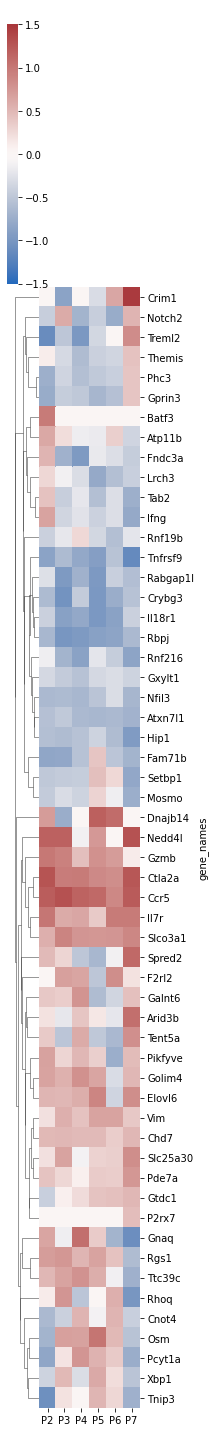

In [8]:
###----- Il2 promoted gene heatmap
out_figure = meta_dir + "/Arm_vs_Cl13_fc---Il2_stat5_promoted.png"
out_csv = meta_dir + "/Arm_vs_Cl13_fc---Il2_stat5_promoted.csv"

il2_stat5_promoted_genes_use = [x for x in il2_stat5_promoted_genes if x in avc_hv_df_slt_sqrt.index.tolist()]
r_df = avc_hv_df_slt_sqrt.loc[il2_stat5_promoted_genes_use]
# With labels
r_hm = sns.clustermap(r_df, cmap="vlag", vmin=-1.5, vmax=1.5, 
                      col_cluster=False, method='centroid', figsize=(3,20))
r_hm.savefig(out_figure)
plt.show()
plt.close()

# Without labels
r_hm = sns.clustermap(r_df, cmap="vlag", vmin=-1.5, vmax=1.5, 
                      yticklabels=False, xticklabels=False, cbar_pos=None,
                      col_cluster=False, method='centroid', figsize=(3,20))
r_hm_ax = r_hm.ax_heatmap
r_hm_ax.set_xlabel("")
r_hm_ax.set_ylabel("")
r_hm_ax.set_xticklabels([])
r_hm.savefig(out_figure.replace(".png", "_noleg.png"))
plt.close()

r_hm_dgram = r_hm.dendrogram_row.dendrogram
r_hm_order = [r_df.index.tolist()[int(x)] for x in r_hm_dgram['ivl']]
r_hm_order_df = avc_hv_df.loc[r_hm_order]
r_hm_order_df.to_csv(out_csv)